# Python Lecture 10: Financial Methods
## Jarret Petrillo copyright 2020
## AMS 595

# Today's Goal

## Introduce non-linear portfolio optimization

1. financial data
2. Monte Carlo
3. non-linaer optimization

Reference: *Python for Finance Cookbook* by Lewinson

In [6]:
import pandas_datareader as pdr # data importer

tesla_daily = pdr.DataReader('TSLA', data_source='yahoo', start='2010-01-01',
                           end='2020-09-08')

tesla_daily.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-06-29,5.000,3.508,3.800,4.778,93831500.0,4.778
2010-06-30,6.084,4.660,5.158,4.766,85935500.0,4.766
2010-07-01,5.184,4.054,5.000,4.392,41094000.0,4.392
2010-07-02,4.620,3.742,4.600,3.840,25699000.0,3.840
2010-07-06,4.000,3.166,4.000,3.222,34334500.0,3.222


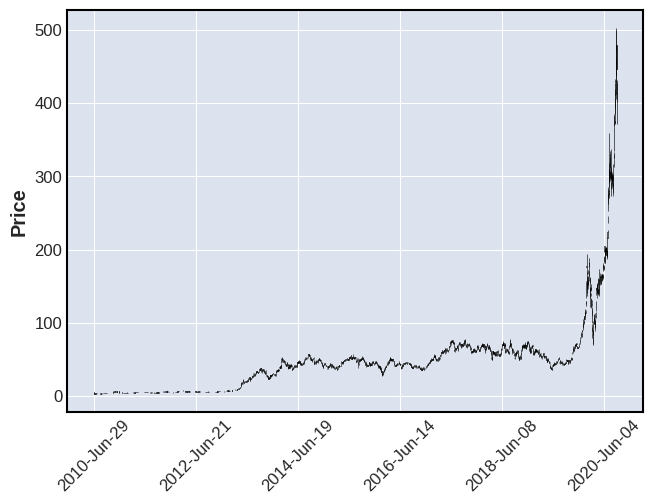

In [7]:
import mplfinance as mpf # professional-looking charts

mpf.plot(tesla_daily, type='candle')

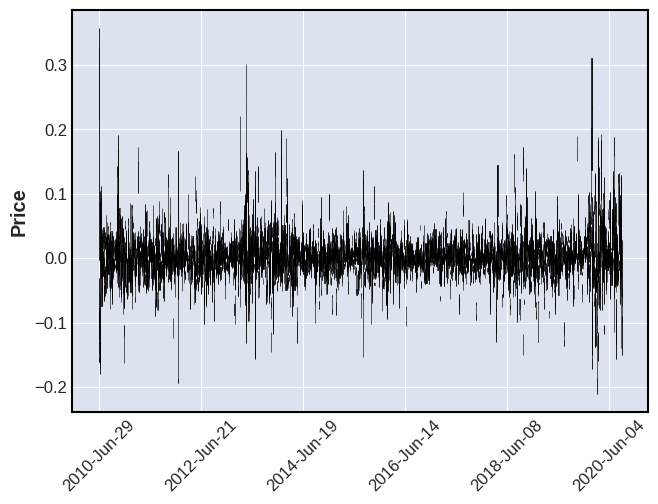

In [15]:
# daily returns

mpf.plot(tesla_daily.pct_change(), type='candle')

In [16]:
# portfolio data
import pandas as pd

stocks = ['GOOGL', 'AAPL', 'JPM', 'FB']
source = 'yahoo'
start = '2015-01-01'
end = '2020-09-08'

data = dict()
for symbol in stocks:
        data[symbol] = pdr.DataReader(symbol, 
                                      data_source=source, 
                                      start=start, 
                                      end=end)['Adj Close']
df = pd.DataFrame(data)

In [13]:
import numpy as np

returns = (df - df.shift(1)) / df.shift(1)

returns.mean() 
returns.cov() # covariance matrix
print(returns.corr()) # correlation matrix

          GOOGL      AAPL       JPM        FB
GOOGL  1.000000  0.610022  0.497349  0.670090
AAPL   0.610022  1.000000  0.508752  0.566905
JPM    0.497349  0.508752  1.000000  0.419823
FB     0.670090  0.566905  0.419823  1.000000


In [36]:
num_days = 252 # usual number of trading days per year
avg_returns = df.pct_change().mean()*num_days
covar_mat = df.pct_change().cov()*num_days
np.random.seed(42) # seed random generator

# Monte Carlo simulation
N_PORTFOLIOS = 25000
weights = np.random.random(size=(N_PORTFOLIOS, len(stocks)))
weights /= np.sum(weights,axis=1).reshape(N_PORTFOLIOS,1)
port_return = np.dot(weights, avg_returns)
port_stdev = []
for i in range(0,N_PORTFOLIOS):
    port_var = np.dot(weights[i].T,np.dot(covar_mat, weights[i]))
    port_stdev.append(np.sqrt(port_var))
port_std = np.array(port_stdev)
port_sharpe = port_return/port_std

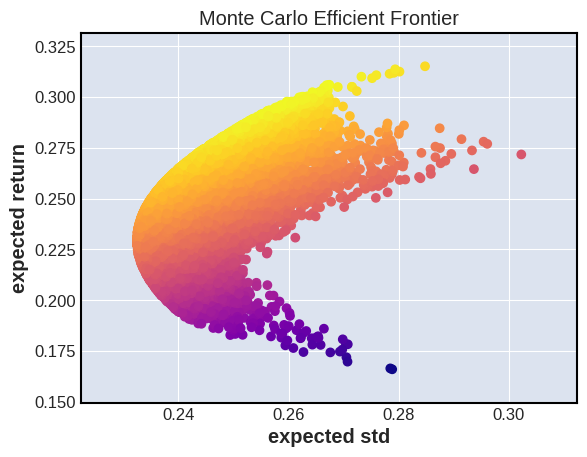

In [38]:
import matplotlib.pyplot as plt

plt.scatter(port_std, 
            port_return, 
            c=port_sharpe,
           cmap = 'plasma') # c is colormap
plt.xlabel("expected std")
plt.ylabel("expected return")
plt.title("Monte Carlo Efficient Frontier")
plt.show()

In [42]:
# optimized portfolio calculation

def get_portf_rtn(w, avg_rtns):
    return np.sum(avg_rtns * w)

def get_portf_vol(w, avg_rtns, cov_mat):
    return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

def get_efficient_frontier(avg_rtns, cov_mat, rtns_range):
    efficient_portfolios = []
    n_assets = len(avg_returns)
    args = (avg_returns, cov_mat)
    bounds = tuple((0,1) for asset in range(n_assets))
    initial_guess = n_assets * [1. / n_assets, ]
    for ret in rtns_range:
        constraints = ({'type': 'eq',
                        'fun': lambda x: get_portf_rtn(x, avg_rtns)- ret},
                        {'type': 'eq',
                    'fun': lambda x: np.sum(x) - 1})
        efficient_portfolio = sco.minimize(get_portf_vol,
                    initial_guess,
                        args=args,
                    method='SLSQP',
                    constraints=constraints,
                    bounds=bounds)
        efficient_portfolios.append(efficient_portfolio)
    return efficient_portfolios


In [63]:
rtns_range = np.linspace(0.10, 0.30, 100)
efficient_result = get_efficient_frontier(avg_returns, 
                                          covar_mat, 
                                          rtns_range)
vols_range = [x['fun'] for x in efficient_result]

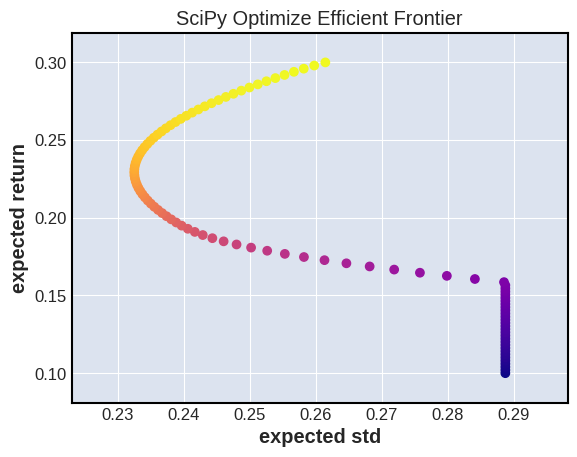

In [66]:
# Plot optimal portfolios

plt.scatter(vols_range, 
            rtns_range, c=rtns_range/vols_range, cmap='plasma') 
plt.xlabel("expected std")
plt.ylabel("expected return")
plt.title("SciPy Optimize Efficient Frontier")
plt.show()

# Thank you for your attention these 10 lectures!

Please send any questions to first.last at stonybrook, or join *office-hours* Wednesday 12pm-1pm

Good luck on the module assesment and your projects!